# Классификация текста с помощью трансформера BERT

Оригинальная идея подчерпнута отсюда https://www.kaggle.com/c/learn-ai-bbc и отсюда https://habr.com/ru/post/655517/


### Импорт библиотек

In [93]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from bs4 import BeautifulSoup
import pickle


tqdm.pandas()

device = torch.device('cuda')
print(device)

cuda


### Чтение нашего датасета, состоящего описаний категорий и ТНВЭД


In [78]:
df = pd.read_csv('dataset.csv', index_col=0)
display(df)

,OPISANIE_CLEAN,TNVED,TNVED2
0,части принадлежности аппаратуры поз 9025 военн...,9025,90
1,трансформаторы мощностью 1 ква 16 ква лом элек...,8504,85
2,клапаны запорные стали военного назначения,8481,84
3,устройства сигнализационные охранные устройств...,8531,85
4,вещества поверхностно активные органические ан...,3402,34
...,...,...,...
4177894,минеральное моторное масло всесезонное дизельн...,2710,27
4177895,синтетическое моторное масло всесезонное дизел...,3403,34
4177896,синтетическое моторное масло всесезонное дизел...,3403,34
4177897,масло трансмиссионное синтетической основе сод...,3403,34


In [79]:
df2 = pd.read_csv('tnved.csv', index_col=0)
df2 = df2.rename(columns={'TNVED_SHORT': 'TNVED'})
display(df2)

,OPISANIE_CLEAN,TNVED,TNVED2
,,,
1,лошади живые чистопородные племенные животные,101,1
2,лошади ослы мулы лошаки живые прочие,101,1
3,прочие лошади живые прочие,101,1
4,ослы живые,101,1
5,прочие мулы лошаки живые,101,1
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,97
12319,подлинники скульптур статуэток любых материалов,9703,97
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,97


In [204]:
df_train = df.sample(frac=.05, random_state=111, weights='TNVED')
df_train = pd.concat([df_train,df2])
display(df_train)

,OPISANIE_CLEAN,TNVED,TNVED2
2554207,устройства вычислительных машин отладочная пла...,8471,84
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62
1817482,электрические части оборудования,8548,85
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95
...,...,...,...
12318,подлинники гравюр эстампов литографий,9702,97
12319,подлинники скульптур статуэток любых материалов,9703,97
12320,марки почтовые марки госпошлин знаки почтовой ...,9704,97
12321,коллекции предметы коллекционирования зоологии...,9705,97


In [205]:
# delete small classes
df_train = df_train[df_train.groupby('TNVED').TNVED.transform('count')>40].copy() 
display(df_train)


,OPISANIE_CLEAN,TNVED,TNVED2
2554207,устройства вычислительных машин отладочная пла...,8471,84
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62
1817482,электрические части оборудования,8548,85
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95
...,...,...,...
12311,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12312,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12313,моноопоры двуноги треноги аналогичные изделия ...,9620,96
12314,моноопоры двуноги треноги аналогичные изделия ...,9620,96


In [206]:
all_tnved = np.unique(df_train['TNVED'])
print(len(all_tnved), all_tnved)
with open('new_keys.pickle', 'wb') as handle:
    pickle.dump(tokens_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

474 [ 203  207  302  303  304  305  306  307  403  406  602  603  709  805
  806  808  810 1006 1104 1515 1602 1604 1605 1701 1704 1806 1901 1902
 1905 2001 2004 2005 2007 2008 2009 2101 2103 2106 2202 2203 2204 2208
 2309 2701 2710 2711 2803 2836 2903 2905 2915 2918 2921 2922 2933 3002
 3004 3005 3006 3102 3105 3204 3206 3208 3209 3214 3215 3301 3302 3303
 3304 3305 3306 3307 3401 3402 3403 3405 3505 3506 3808 3811 3814 3820
 3822 3824 3901 3902 3903 3904 3905 3906 3907 3909 3910 3916 3917 3918
 3919 3920 3921 3922 3923 3924 3925 3926 4002 4008 4009 4010 4011 4012
 4015 4016 4202 4203 4302 4303 4401 4403 4407 4408 4409 4410 4411 4412
 4415 4418 4419 4420 4421 4602 4703 4801 4802 4804 4805 4810 4811 4818
 4819 4820 4821 4823 4901 4911 5205 5208 5401 5402 5407 5514 5601 5603
 5607 5702 5703 5705 5801 5806 5903 5911 6001 6006 6101 6102 6103 6104
 6105 6106 6107 6108 6109 6110 6111 6112 6113 6114 6115 6116 6117 6201
 6202 6203 6204 6205 6206 6207 6208 6209 6210 6211 6212 6214 6216 6217
 6

In [207]:
print(int(np.where(all_tnved == 9620)[0]))

473


Make new keys

In [208]:
df_train['target']=df_train['TNVED'].apply(lambda x: int(np.where(all_tnved == x)[0]))

In [209]:
display(df_train)

,OPISANIE_CLEAN,TNVED,TNVED2,target
2554207,устройства вычислительных машин отладочная пла...,8471,84,357
706914,бюстгальтеры женские рост 185 см обхват груди ...,6212,62,192
1817482,электрические части оборудования,8548,85,411
3212186,пиловочник осиновый тополь дрожащий осина popu...,4403,44,119
1231522,принадлежности рыбной ловли блесна вращающаяся...,9507,95,463
...,...,...,...,...
12311,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12312,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12313,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473
12314,моноопоры двуноги треноги аналогичные изделия ...,9620,96,473


### Загрузка претренированной модели

In [185]:
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

### Разбиение выборок на текст и таргет

In [ ]:
with open('X_train.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)
with open('X_test.pickle', 'rb') as handle:
    X_test = pickle.load(handle)
with open('y_test.pickle', 'rb') as handle:
    y_test = pickle.load(handle)

In [210]:
X = df_train['OPISANIE_CLEAN'].astype(str)
y = df_train['target'].astype(int)

X_train, y_train = X,y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

print(np.unique(y_train).shape)
print(np.unique(y_test).shape)

(474,)
(474,)


In [211]:
with open('X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

График длин текстов. Он поможет определить оптимальную длину последовательности токенов, чтобы избежать разреженных векторов.

<AxesSubplot:>

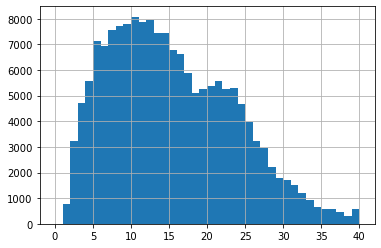

In [212]:
seq_len = [len(str(i).split()) for i in X_train]
pd.Series(seq_len).hist(bins = 40, range =(0,40))

### Токенизация текста
Берем длину 15

In [9]:
with open('tokens_train.pickle', 'rb') as handle:
    tokens_train = pickle.load(handle)
    
with open('tokens_test.pickle', 'rb') as handle:
    tokens_test = pickle.load(handle)

In [213]:
token_len = 15

tokens_train = tokenizer.batch_encode_plus(
    X_train.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    X_test.values,
    max_length = token_len,
    padding = 'max_length',
    truncation = True
)

In [214]:
with open('tokens_train.pickle', 'wb') as handle:
    pickle.dump(tokens_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokens_test.pickle', 'wb') as handle:
    pickle.dump(tokens_test, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Создание датасета для обучения из токенов

In [215]:
batch_size = 4


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data =  TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [ ]:
print(test_data[0])

### Вместо обучения всего BERT добавим слой для классификации

In [216]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,474)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

### Загрузка модели в GPU

In [15]:
torch.cuda.empty_cache()

In [217]:
model = BERT_Arch(bert)

model = model.to(device)
from torch.optim import AdamW

optimizer = AdamW(model.parameters())

### Нормализация весов в зависимости от соотношения классов в выборке трейна

In [218]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights += 0.1

#print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
#cross_entropy = nn.CrossEntropyLoss()
cross_entropy = nn.NLLLoss(weight=weights)
epochs = 20

/home/eugene/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215

Функция для наглядного обучения модели

In [219]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        #print(loss)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

Функция для тестирования модели

In [220]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    
    return avg_loss, total_preds

Обучение новых слоев для задачи классификации

In [ ]:
best_test_loss = float('inf')

train_losses = []
test_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    test_loss, _ = evaluate()
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Test loss: {test_loss:.3f}')
    
    
def train_acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

aa,bb = train_acc()    
    
def acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = acc()


 Epoch1 / 20


100%|██████████| 10594/10594 [02:59<00:00, 58.88it/s]



Training loss: 4.244
Test loss: 3.094

 Epoch2 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.29it/s]



Training loss: 3.448
Test loss: 2.888

 Epoch3 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.25it/s]



Training loss: 3.286
Test loss: 2.885

 Epoch4 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.10it/s]



Training loss: 3.195
Test loss: 2.674

 Epoch5 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.13it/s]



Training loss: 3.146
Test loss: 2.545

 Epoch6 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.12it/s]



Training loss: 3.087
Test loss: 2.513

 Epoch7 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.15it/s]



Training loss: 3.048
Test loss: 2.477

 Epoch8 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.32it/s]



Training loss: 3.006
Test loss: 2.543

 Epoch9 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.28it/s]



Training loss: 2.985
Test loss: 2.482

 Epoch10 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.15it/s]



Training loss: 2.962
Test loss: 2.401

 Epoch11 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.21it/s]



Training loss: 2.939
Test loss: 2.423

 Epoch12 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.32it/s]



Training loss: 2.919
Test loss: 2.434

 Epoch13 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.40it/s]



Training loss: 2.907
Test loss: 2.506

 Epoch14 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.24it/s]



Training loss: 2.899
Test loss: 2.330

 Epoch15 / 20


100%|██████████| 10594/10594 [02:59<00:00, 59.08it/s]



Training loss: 2.884
Test loss: 2.409

 Epoch16 / 20


100%|██████████| 10594/10594 [02:46<00:00, 63.57it/s]



Training loss: 2.875
Test loss: 2.420

 Epoch17 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.23it/s]



Training loss: 2.867
Test loss: 2.526

 Epoch18 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.31it/s]



Training loss: 2.859
Test loss: 2.414

 Epoch19 / 20


100%|██████████| 10594/10594 [02:58<00:00, 59.20it/s]



Training loss: 2.861
Test loss: 2.359

 Epoch20 / 20


 79%|███████▊  | 33299/42375 [13:07<03:35, 42.06it/s]

Загружаем лучшую модель для предсказания

In [ ]:
model.eval()

In [ ]:
#path = '474_v2_saved_weights.pt'
#model.load_state_dict(torch.load(path))
#model.eval()

### Предсказываем


In [ ]:
def predict_dataloader(predict_dataloader):
    total_preds = []
    total_labels = []
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = preds.argmax(axis=1)
            labels = labels.cpu().numpy()
            total_preds.append(preds)
            total_labels.append(labels)
            
    return total_preds, total_labels


def predict_df(df):
    df = df.copy()
    batch_size = 1
    tokens_predict = tokenizer.batch_encode_plus(
        df['OPISANIE_CLEAN'].values,
        max_length = 15,
        padding = 'max_length',
        truncation = True
    )
    
    total_preds = []
    
    predict_seq = torch.tensor(tokens_predict['input_ids'])
    predict_mask = torch.tensor(tokens_predict['attention_mask'])
    predict_data =  TensorDataset(predict_seq, predict_mask)
    predict_sampler = SequentialSampler(predict_data)
    predict_dataloader = DataLoader(predict_data, sampler = predict_sampler, batch_size = batch_size)
    
    
    for step, batch in tqdm(enumerate(predict_dataloader), total = len(predict_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()    
            preds = np.argmax(preds)
            total_preds.append(preds)
    df['target'] = total_preds
    return df

#pred_df = predict_df(test_df)
#display(pred_df)

a, b = predict_dataloader(test_dataloader)

a = np.hstack(a)
b = np.hstack(b)

for x in zip(a,b):
    print(x[0], x[1])

In [76]:
def train_acc():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []
    total_acc_test = 0

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            #labels= labels.unsqueeze(1)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            
            test_labels = labels.to(device)
            acc = (preds.argmax(dim=1) == test_labels).sum().item()
            total_acc_test += acc            
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            


    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    print(f'Test Accuracy: {total_acc_test / len(total_preds): .3f}')
    return avg_loss, total_preds

a,b = train_acc()

100%|██████████| 16929/16929 [04:50<00:00, 58.37it/s]


Test Accuracy:  0.664
